In [ ]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import glob
import pandas as pd

time: 1.12 ms (started: 2022-10-07 19:59:03 +00:00)


In [ ]:
!pip install ipython-autotime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
time: 3.35 s (started: 2022-10-07 19:59:04 +00:00)


In [ ]:
%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 4.13 ms (started: 2022-10-07 19:59:07 +00:00)


In [ ]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython
time: 1.21 ms (started: 2022-10-07 19:59:07 +00:00)


# Importamos imágenes desde GitHub

In [ ]:
# Clonamos el repositorio
!git clone https://github.com/BenjaminIrarrazabal/Procesamiento_Avanzado_de_Imagenes

Cloning into 'Procesamiento_Avanzado_de_Imagenes'...
remote: Enumerating objects: 381, done.
remote: Counting objects: 100% (381/381), done.
remote: Compressing objects: 100% (380/380), done.
remote: Total 381 (delta 1), reused 376 (delta 1), pack-reused 0
Receiving objects: 100% (381/381), 34.01 MiB | 16.79 MiB/s, done.
Resolving deltas: 100% (1/1), done.
time: 4.36 s (started: 2022-10-07 19:59:07 +00:00)


In [ ]:
# Nos posicionamos en la carpeta de imágenes de la tarea 3
%cd Procesamiento_Avanzado_de_Imagenes/ImagenesT3

/content/Procesamiento_Avanzado_de_Imagenes/ImagenesT3/Procesamiento_Avanzado_de_Imagenes/ImagenesT3
time: 5.65 ms (started: 2022-10-07 19:59:11 +00:00)


In [ ]:
# Confirmamos que estén las carpetas
!ls

car_side  chair  pedestrian
time: 141 ms (started: 2022-10-07 19:59:11 +00:00)


# Funciones por definir

## Gradiente (x e y), extraídas de Tarea 2

In [ ]:
%%cython
import cython
import numpy as np
cimport numpy as np

cpdef np.ndarray[np.float32_t, ndim=2] gradx(np.ndarray[np.float32_t, ndim=2] input):
  cdef np.ndarray[np.float32_t, ndim=2] output=np.zeros([input.shape[0], input.shape[1]], dtype = np.float32)

  cdef int i, j # indices para recorrer la imagen de entrada

  for i in range(input.shape[0]): # se recorren todas las filas
    for j in range(1, input.shape[1] - 1): # se evitan los bordes para calzar con la aproximación [-1, 0, 1]
      output[i,j] = (input[i,j+1] - input[i,j-1]) # se aplica la convolución

  return output

time: 3.44 ms (started: 2022-10-07 19:59:12 +00:00)


In [ ]:
%%cython
import cython
import numpy as np
cimport numpy as np

cpdef np.ndarray[np.float32_t, ndim=2] grady(np.ndarray[np.float32_t, ndim=2] input):
  cdef np.ndarray[np.float32_t, ndim=2] output=np.zeros([input.shape[0], input.shape[1]], dtype = np.float32)

  cdef int i, j # indices para recorrer la imagen de entrada

  for i in range(1, input.shape[0] - 1): # se evitan los bordes para calzar con la aproximación [-1, 0, 1]^T
    for j in range(input.shape[1]): # se recorren todas las columnas
      output[i,j] = (input[i+1,j] - input[i-1,j]) # se aplica la convolución
  return output

time: 2.82 ms (started: 2022-10-07 19:59:12 +00:00)


In [ ]:
# Función que retorna ambos gradientes (centrales ya que se utiliza kernel [-1, 0, 1])
def gradientes(img):
  return gradx(img), grady(img)

time: 1.05 ms (started: 2022-10-07 19:59:12 +00:00)


# Transformar a escala de grises y redimensionar

In [ ]:
# gray_redimension toma una imagen de entrada y la transforma a escala de grises
# luego, realiza un reshape para que la imagen de salida sea del tamaño 64x128 pixeles.

def gray_redimension(img):
  # Se transforma a escala de grises
  gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  # Se redimensiona la imagen
  out_img = cv2.resize(gray_img, dsize=(64, 128), interpolation = cv2.INTER_CUBIC)
  return np.float32(out_img)

time: 3.61 ms (started: 2022-10-07 19:59:12 +00:00)


In [ ]:
# Función auxiliar creada para probar un ejemplo
def plot_redimension(img):
  print('Imagen Original', img.shape)
  cv2_imshow(img)
  final = gray_redimension(img)
  print('Imagen post redimension', final.shape)
  cv2_imshow(final)

time: 1.4 ms (started: 2022-10-07 19:59:12 +00:00)


Imagen Original (90, 36, 3)


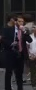

Imagen post redimension (128, 64)


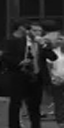

time: 28.3 ms (started: 2022-10-07 19:59:12 +00:00)


In [ ]:
# Realizamos una prueba de la función anterior
img = cv2.imread('pedestrian/1.png')
plot_redimension(img)

# HOG

In [ ]:
%%cython
import cython
import numpy as np
cimport numpy as np

cpdef np.ndarray[np.float32_t, ndim=2] magnitude(np.ndarray[np.float32_t, ndim=2] gx, np.ndarray[np.float32_t, ndim=2] gy):
  cdef np.ndarray[np.float32_t, ndim=2] magnitude = np.zeros([gx.shape[0], gx.shape[1]], dtype = np.float32)

  cdef int i, j # enteros para recorrer los gradientes

  # Recorremos los gradientes que entran a la función
  for i in range(magnitude.shape[0]):
    for j in range(magnitude.shape[1]):
      # Calculamos la magnitud 
      magnitude[i,j] = np.sqrt(gx[i,j]**2 + gy[i,j]**2)
  return magnitude

time: 9.99 ms (started: 2022-10-07 19:59:12 +00:00)


In [ ]:
%%cython
import cython
import numpy as np
cimport numpy as np

cpdef np.ndarray[np.float32_t, ndim=2] angle(np.ndarray[np.float32_t, ndim=2] gx, np.ndarray[np.float32_t, ndim=2] gy):
  cdef np.ndarray[np.float32_t, ndim=2] angle = np.zeros([gx.shape[0], gx.shape[1]], dtype = np.float32)

  cdef int i, j # enteros para recorrer los gradientes

  # Recorremos los gradientes que entran a la función
  for i in range(angle.shape[0]):
    for j in range(angle.shape[1]):
      # Calculamos la dirección
      angle[i,j] = np.arctan2(gx[i,j], gy[i,j]) * 180 / np.pi
      if angle[i,j] < 0:
        angle[i,j] += 360
  return angle

time: 11.4 ms (started: 2022-10-07 19:59:12 +00:00)


In [ ]:
def HOG_Features(magnitude, angle):
  # Se crea el arreglo de ceros
  Features = np.zeros([16, 8, 9], dtype = np.float32)
  # Se recorre el arreglo para tener todos los ángulos entre 0 y 180
  for i in range(angle.shape[0]):
    for j in range(angle.shape[1]):
      if angle[i,j] >= 180:
        angle[i,j] -= 180

  
  # Se recorre para extraer las características
  for i in range(angle.shape[0]):
    for j in range(angle.shape[1]):
      # k permite saber si estamos sobre un bin (0, 20, 40, 60...)
      k = angle[i,j]%20
      # m permite encontrar la posición del bin (0, 1, 2, 3....)
      m = int(angle[i,j] // 20)
      # Si k es cero, significa que toda la magnitud va al bin m
      if k == 0: 
        Features[i//8, j//8, m] += magnitude[i,j]
      # si k es distinto de cero:
      else:
        # se calculan ponderaciones
        p1 = (angle[i,j] / 20) - m
        p2 = m + 1 - (angle[i,j] / 20)
        # si m es el ultimo bin, solo se agrega a este
        if m==8:
          Features[i//8, j//8, m] += (magnitude[i,j] * p2)
        # si no, se reparte según las ponderaciones obtenidas
        else:
          Features[i//8, j//8, m] += (magnitude[i,j] * p2)
          Features[i//8, j//8, m+1] += (magnitude[i,j] * p1)
  return Features

time: 25 ms (started: 2022-10-07 19:59:12 +00:00)


In [ ]:
def Block_Normalization(features):
  # Se crean dos listas vacías que guardarán la información
  feature_vector = []
  normalized_vector = []
  # Se recorre el vector de 16x8x9 hasta antes de los extremos (para usar bloques de 2x2 celdas)
  for i in range(features.shape[0]-1):
    for j in range(features.shape[1]-1):
      # Se agregan las features de las celdas correspondientes
      normalized_vector.append(features[i,j])
      normalized_vector.append(features[i,j+1])
      normalized_vector.append(features[i+1,j])
      normalized_vector.append(features[i+1,j+1])
      # si el valor de las celdas es distinto a cero, se normaliza
      if np.sum(normalized_vector) != 0:
        normalized_vector = np.array(normalized_vector) / np.sum(normalized_vector)
  # se retorna el vector de características de 1x3780
      feature_vector.append(normalized_vector)
      normalized_vector = []
  feature_vector = np.float32(feature_vector)
  feature_vector = feature_vector.reshape((1, 3780))
  return np.float32(feature_vector[0])

time: 15.9 ms (started: 2022-10-07 19:59:12 +00:00)


In [ ]:
def HOG(img):
  # Se aplica la redimensión y transformación a escala de grises
  img_resized = gray_redimension(img)
  # Se computan gradientes en x e y
  gx, gy = gradientes(img_resized)
  # Se obtienen las matrices de magnitud y dirección (ángulos)
  mag = magnitude(gx, gy)
  ang = angle(gx, gy)
  # Se extraen las características
  FeaturesHOG = HOG_Features(mag, ang)
  # Se normalizan features y se retorna el vector de largo 3780
  features_vector = Block_Normalization(FeaturesHOG)
  return features_vector

time: 5.88 ms (started: 2022-10-07 19:59:12 +00:00)


# Feature Extractor

In [ ]:
pedestrian_path = glob.glob('pedestrian//*.png') # nombres en file[11:-4]
chair_path = glob.glob('chair//*.jpg') # nombres en file[6:-4]
car_path = glob.glob('car_side//*.jpg') # nombres en file[9:-4]

Features = []
Class = []

for file in pedestrian_path:
    img = cv2.imread(file)
    feature = HOG(img)
    Features.append(feature)
    Class.append(0)

for file in chair_path:
    img = cv2.imread(file)
    feature = HOG(img)
    Features.append(feature)
    Class.append(1)

for file in car_path:
    img = cv2.imread(file)
    feature = HOG(img)
    Features.append(feature)
    Class.append(2)

time: 1min 27s (started: 2022-10-07 19:59:12 +00:00)


# Entrenamiento y Clasificaciones

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import PredefinedSplit

X_80, X_test, Y_80, Y_test = train_test_split(Features, np.array(Class), test_size=0.20, stratify=Class)

X_train, X_val, Y_train, Y_val = train_test_split(X_80, Y_80, train_size=0.75)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_80 = scaler.transform(X_80)
X_test = scaler.transform (X_test)

test_fold = [-1 for _ in range(int(len(X_80)*0.75))] + [0 for _ in range(int(len(X_80)*0.25))]

PSplit = PredefinedSplit(test_fold)

time: 32.5 ms (started: 2022-10-07 21:15:48 +00:00)


## Support Vector Machines

In [ ]:

from sklearn.model_selection import GridSearchCV
# Grid Search para Support Vector Machines
model = SVC()
parametros = {'C': [0.01, 0.1, 1.0, 10, 100, 1000],
              'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
              'gamma': [0.01, 0.1, 1.0, 10, 'scale', 'auto']}

grid = GridSearchCV(model, parametros, cv=PSplit)
grid.fit(X_80, Y_80)
grid.best_estimator_

SVC(kernel='sigmoid')

time: 16 s (started: 2022-10-07 21:17:43 +00:00)


In [ ]:
# Clasificación usando el mejor modelo encontrado
classifier = SVC(kernel = 'sigmoid')
classifier.fit(X_train, Y_train)

Y_pred = classifier.predict(X_test)
print('Accuracy Test SVM: ', accuracy_score(Y_test, Y_pred))

Accuracy Test SVM:  0.9864864864864865
time: 79.1 ms (started: 2022-10-07 21:18:24 +00:00)


Text(30.5, 0.5, 'True Labels')

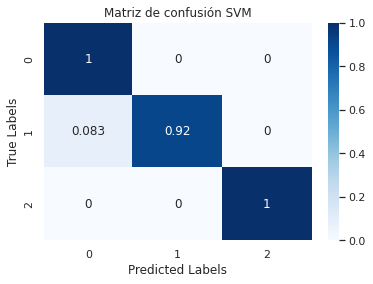

time: 271 ms (started: 2022-10-07 21:18:26 +00:00)


In [ ]:
import seaborn as sn
sn.set()
f,ax=plt.subplots()
cm = confusion_matrix(Y_test, Y_pred, normalize = 'true')
sn.heatmap(cm,annot=True,ax=ax, cmap = 'Blues') 

ax.set_title('Matriz de confusión SVM') 
ax.set_xlabel('Predicted Labels') 
ax.set_ylabel('True Labels') 

## Random Forests

In [ ]:

from sklearn.model_selection import GridSearchCV
# Grid Search para RandomForest
model = RandomForestClassifier()
parametros = {'n_estimators': [20, 50, 70, 100, 130, 180],
              'criterion': ['gini', 'entropy', 'log_loss'],
              'max_depth': [5, 10, 20, 30, 40, 100],
              'max_features': ['sqrt', 'log2'], 
              'n_jobs': [1, -1]}
grid = GridSearchCV(model, parametros, cv=PSplit)
grid.fit(X_80, Y_80)
grid.best_estimator_


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
144 fits failed out of a total of 432.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
72 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py", line 467, in fit
    for i, t in enumerate(trees)
  File "/usr/local/lib/python3.7/dist-packages/joblib/parallel.py", line 1085, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.7/dist-packages/joblib/pa

RandomForestClassifier(max_depth=100, max_features='log2', n_estimators=70,
                       n_jobs=-1)

time: 4min 2s (started: 2022-10-07 21:19:03 +00:00)


In [ ]:
classifier = RandomForestClassifier(max_depth=10, max_features='sqrt', n_estimators=50, n_jobs=-1)
classifier.fit(X_train, Y_train)

Y_pred = classifier.predict(X_test)
print('Accuracy Test RF: ', accuracy_score(Y_test, Y_pred))

Accuracy Test RF:  0.9459459459459459
time: 333 ms (started: 2022-10-07 21:34:31 +00:00)


Text(30.5, 0.5, 'True Labels')

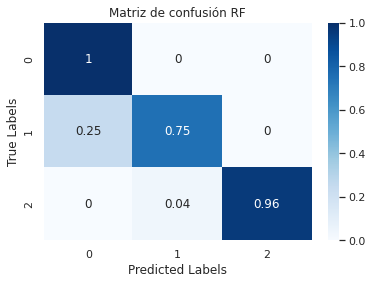

time: 268 ms (started: 2022-10-07 21:34:32 +00:00)


In [ ]:
import seaborn as sn
sn.set()
f,ax=plt.subplots()
cm = confusion_matrix(Y_test, Y_pred, normalize = 'true')
sn.heatmap(cm,annot=True,ax=ax, cmap = 'Blues') 

ax.set_title('Matriz de confusión RF') 
ax.set_xlabel('Predicted Labels') 
ax.set_ylabel('True Labels') 

# Interpolación Bilinear

In [ ]:
def HOG_Features_Bilinearly(magnitude, angle):
  # Se crea el arreglo de features
  Features = np.zeros([16, 8, 9], dtype = np.float32)
  # Se recorren los ángulos para que estén entre 0 y 180
  for i in range(angle.shape[0]):
    for j in range(angle.shape[1]):
      if angle[i,j] >= 180:
        angle[i,j] -= 180
  # Se recorren los extremos y se aplica el mismo funcionamiendo que HOF_Features
  # es decir, no se usa la interpolación
  for i in range(angle.shape[0]-8, angle.shape[0]):
    for j in range(angle.shape[1]-8, angle.shape[1]):
      k = angle[i,j]%20
      m = int(angle[i,j] // 20)
      if k == 0: 
        Features[i//8, j//8, m] += magnitude[i,j]
      else:
        p1 = (angle[i,j] / 20) - m
        p2 = m + 1 - (angle[i,j] / 20)
        if m==8:
          Features[i//8, j//8, m] += (magnitude[i,j] * p2)
        else:
          Features[i//8, j//8, m] += (magnitude[i,j] * p2)
          Features[i//8, j//8, m+1] += (magnitude[i,j] * p1)
  # Para los casos generales se aplica la interpolación de la siguiente manera
  for i in range(angle.shape[0]-8):
    for j in range(angle.shape[1]-8):
      # k y m funcionan de igual manera que antes
      k = angle[i,j]%20
      m = int(angle[i,j] // 20)

      p1 = (angle[i,j] / 20) - m        #  Ponderación bin más lejano
      p2 = m + 1 - (angle[i,j] / 20)    #  Ponderación bin más cercano

      # Las celdas más cercanas se determinan mediante un bloque de 2x2
      c1 = Features[i//8, j//8]         # Celda directamente más cercana
      c2 = Features[i//8, (j//8)+1]     # Celda de la derecha
      c3 = Features[(i//8)+1, j//8]     # Celda de abajo
      c4 = Features[(i//8)+1, (j//8)+1] # Celda diagonal

      # Bines
      b1 = m
      b2 = m + 1

      if (i%4 == 0) and (j%4 == 0): # Si está en el centro de la celda
      # Si está en el centro de la celda, toda la ponderación de magnitud debe ir a esta celda en particular y luego realizar
      # la ponderación interna entre bines
        if m == 8:
          c1[b1] += (magnitude[i,j] * p2)
        else:
          c1[b1] += (magnitude[i,j] * p2)
          c1[b2] += (magnitude[i,j] * p1)

      elif (i%7 == 0) and (j%7 == 0): # Si está entre 4 celdas
      # Si está entre 4 celdas (justo en la unión), se reparte equitativamente y posteriormente se pondera internamente
        if m == 8:
          c1[b1] += (magnitude[i,j] * p2) * 0.25
          c2[b1] += (magnitude[i,j] * p2) * 0.25
          c3[b1] += (magnitude[i,j] * p2) * 0.25
          c4[b1] += (magnitude[i,j] * p2) * 0.25
        else:
          c1[b1] += (magnitude[i,j] * p2) * 0.25
          c2[b1] += (magnitude[i,j] * p2) * 0.25
          c3[b1] += (magnitude[i,j] * p2) * 0.25
          c4[b1] += (magnitude[i,j] * p2) * 0.25

          c1[b2] += (magnitude[i,j] * p1) * 0.25
          c2[b2] += (magnitude[i,j] * p1) * 0.25
          c3[b2] += (magnitude[i,j] * p1) * 0.25
          c4[b2] += (magnitude[i,j] * p1) * 0.25
      else: # Cualquier otro caso
      # En el caso general, se calculan las 4 distancias d1,..., d4
      # estas se intercambian debidamente para ponderar las magnitudes de cada celda y bin respectivo
      # El resto es análogo a todo lo anterior
        d1 = np.abs(i-(i//8 * 8 + 4)) + np.abs(j-(j//8 * 8 + 4))
        d2 = np.abs(i-(i//8 * 8 + 4)) + np.abs(j-(j//8 * 8 + 8)) 
        d3 = np.abs(i-(i//8 * 8 + 8)) + np.abs(j-(j//8 * 8 + 4)) 
        d4 = np.abs(i-(i//8 * 8 + 8)) + np.abs(j-(j//8 * 8 + 8)) 
        t = d1+d2+d3+d4
        if m == 8:
          if d2 > d3:
            c1[b1] += (magnitude[i,j] * p2) * (d4/t)
            c2[b1] += (magnitude[i,j] * p2) * (d3/t)
            c3[b1] += (magnitude[i,j] * p2) * (d2/t)
            c4[b1] += (magnitude[i,j] * p2) * (d1/t)
          else:
            c1[b1] += (magnitude[i,j] * p2) * (d4/t)
            c2[b1] += (magnitude[i,j] * p2) * (d2/t)
            c3[b1] += (magnitude[i,j] * p2) * (d3/t)
            c4[b1] += (magnitude[i,j] * p2) * (d1/t)

        else:
          if d2 > d3:
            c1[b1] += (magnitude[i,j] * p2) * (d4/t)
            c2[b1] += (magnitude[i,j] * p2) * (d3/t)
            c3[b1] += (magnitude[i,j] * p2) * (d2/t)
            c4[b1] += (magnitude[i,j] * p2) * (d1/t)

            c1[b2] += (magnitude[i,j] * p1) * (d4/t)
            c2[b2] += (magnitude[i,j] * p1) * (d3/t)
            c3[b2] += (magnitude[i,j] * p1) * (d2/t)
            c4[b2] += (magnitude[i,j] * p1) * (d1/t)
          else:
            c1[b1] += (magnitude[i,j] * p2) * (d4/t)
            c2[b1] += (magnitude[i,j] * p2) * (d2/t)
            c3[b1] += (magnitude[i,j] * p2) * (d3/t)
            c4[b1] += (magnitude[i,j] * p2) * (d1/t)

            c1[b2] += (magnitude[i,j] * p1) * (d4/t)
            c2[b2] += (magnitude[i,j] * p1) * (d2/t)
            c3[b2] += (magnitude[i,j] * p1) * (d3/t)
            c4[b2] += (magnitude[i,j] * p1) * (d1/t)

  return Features

time: 13.7 ms (started: 2022-10-07 20:03:07 +00:00)


In [ ]:
def HOG_Bilinearly(img):
  # Se aplica la redimensión y transformación a escala de grises
  img_resized = gray_redimension(img)
  # Se computan gradientes en x e y
  gx, gy = gradientes(img_resized)
  # Se obtienen las matrices de magnitud y dirección (ángulos)
  mag = magnitude(gx, gy)
  ang = angle(gx, gy)
  # Se extraen las características
  FeaturesHOG = HOG_Features_Bilinearly(mag, ang)
  # Se normalizan features y se retorna el vector de largo 3780
  features_vector = Block_Normalization(FeaturesHOG)
  return features_vector

time: 1.12 ms (started: 2022-10-07 20:03:07 +00:00)


In [ ]:
pedestrian_path = glob.glob('pedestrian//*.png') # nombres en file[11:-4]
chair_path = glob.glob('chair//*.jpg') # nombres en file[6:-4]
car_path = glob.glob('car_side//*.jpg') # nombres en file[9:-4]

Features_Bi = []
Class_Bi = []

for file in pedestrian_path:
    img = cv2.imread(file)
    feature = HOG_Bilinearly(img)
    Features_Bi.append(feature)
    Class_Bi.append(0)

for file in chair_path:
    img = cv2.imread(file)
    feature = HOG_Bilinearly(img)
    Features_Bi.append(feature)
    Class_Bi.append(1)

for file in car_path:
    img = cv2.imread(file)
    feature = HOG_Bilinearly(img)
    Features_Bi.append(feature)
    Class_Bi.append(2)

time: 2min 59s (started: 2022-10-07 20:03:08 +00:00)


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import PredefinedSplit

X_80, X_test, Y_80, Y_test = train_test_split(Features_Bi, np.array(Class_Bi), test_size=0.20, stratify=Class)

X_train, X_val, Y_train, Y_val = train_test_split(X_80, Y_80, train_size=0.75)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_80 = scaler.transform(X_80)
X_test = scaler.transform (X_test)

test_fold = [-1 for _ in range(int(len(X_80)*0.75))] + [0 for _ in range(int(len(X_80)*0.25))]

PSplit = PredefinedSplit(test_fold)

time: 34.3 ms (started: 2022-10-07 21:24:51 +00:00)


In [ ]:
from sklearn.model_selection import GridSearchCV
# Grid Search para Support Vector Machines
model = SVC()
parametros = {'C': [0.01, 0.1, 1.0, 10, 100, 1000],
              'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
              'gamma': [0.01, 0.1, 1.0, 10, 'scale', 'auto']}

grid = GridSearchCV(model, parametros, cv=PSplit)
grid.fit(X_80, Y_80)
grid.best_estimator_

SVC(C=0.01, gamma=0.01, kernel='linear')

time: 14.3 s (started: 2022-10-07 21:24:57 +00:00)


In [ ]:
classifier = SVC(C=0.01, kernel = 'linear', gamma = 0.01)
classifier.fit(X_train, Y_train)

Y_pred = classifier.predict(X_test)
print('Accuracy Test SVM: ', accuracy_score(Y_test, Y_pred))

Accuracy Test SVM:  0.9459459459459459
time: 62 ms (started: 2022-10-07 21:25:50 +00:00)


Text(30.5, 0.5, 'True Labels')

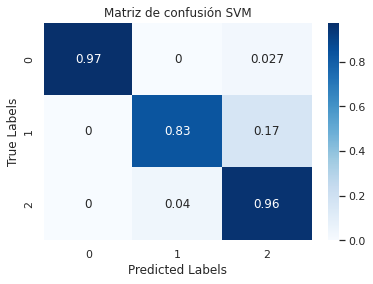

time: 271 ms (started: 2022-10-07 21:25:53 +00:00)


In [ ]:
import seaborn as sn
sn.set()
f,ax=plt.subplots()
cm = confusion_matrix(Y_test, Y_pred, normalize = 'true')
sn.heatmap(cm,annot=True,ax=ax, cmap = 'Blues') 

ax.set_title('Matriz de confusión SVM') 
ax.set_xlabel('Predicted Labels') 
ax.set_ylabel('True Labels') 

In [ ]:
from sklearn.model_selection import GridSearchCV
# Grid Search para RandomForest
model = RandomForestClassifier()
parametros = {'n_estimators': [20, 50, 70, 100, 130, 180],
              'criterion': ['gini', 'entropy', 'log_loss'],
              'max_depth': [5, 10, 20, 30, 40, 100],
              'max_features': ['sqrt', 'log2'], 
              'n_jobs': [1, -1]}
grid = GridSearchCV(model, parametros, cv=PSplit)
grid.fit(X_80, Y_80)
grid.best_estimator_

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
144 fits failed out of a total of 432.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
72 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py", line 467, in fit
    for i, t in enumerate(trees)
  File "/usr/local/lib/python3.7/dist-packages/joblib/parallel.py", line 1085, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.7/dist-packages/joblib/pa

RandomForestClassifier(max_depth=5, max_features='sqrt', n_estimators=50,
                       n_jobs=-1)

time: 3min 52s (started: 2022-10-07 21:26:19 +00:00)


In [ ]:
classifier = RandomForestClassifier(max_depth=5, max_features='sqrt', n_estimators=50, n_jobs=-1)
classifier.fit(X_train, Y_train)

Y_pred = classifier.predict(X_test)
print('Accuracy Test RF: ', accuracy_score(Y_test, Y_pred))

Accuracy Test RF:  0.972972972972973
time: 333 ms (started: 2022-10-07 21:30:43 +00:00)


Text(30.5, 0.5, 'True Labels')

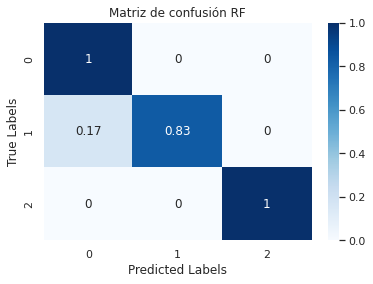

time: 279 ms (started: 2022-10-07 21:30:50 +00:00)


In [ ]:
import seaborn as sn
sn.set()
f,ax=plt.subplots()
cm = confusion_matrix(Y_test, Y_pred, normalize = 'true')
sn.heatmap(cm,annot=True,ax=ax, cmap = 'Blues') 

ax.set_title('Matriz de confusión RF') 
ax.set_xlabel('Predicted Labels') 
ax.set_ylabel('True Labels') 

time: 297 ms (started: 2022-10-07 20:06:08 +00:00)
